In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn import preprocessing

In [3]:
train=pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test=pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

In [5]:
train_n=train.select_dtypes(include=np.number).columns.tolist()
test_n=test.select_dtypes(include=np.number).columns.tolist()

train_c=train.select_dtypes('object').columns.tolist()
test_c=test.select_dtypes('object').columns.tolist()


In [6]:
train_n=train[[c for c in train.columns if train[c].dtypes!='O']].copy()
test_n=test[[c for c in test.columns if test[c].dtypes!='O']].copy()

train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

<AxesSubplot:>

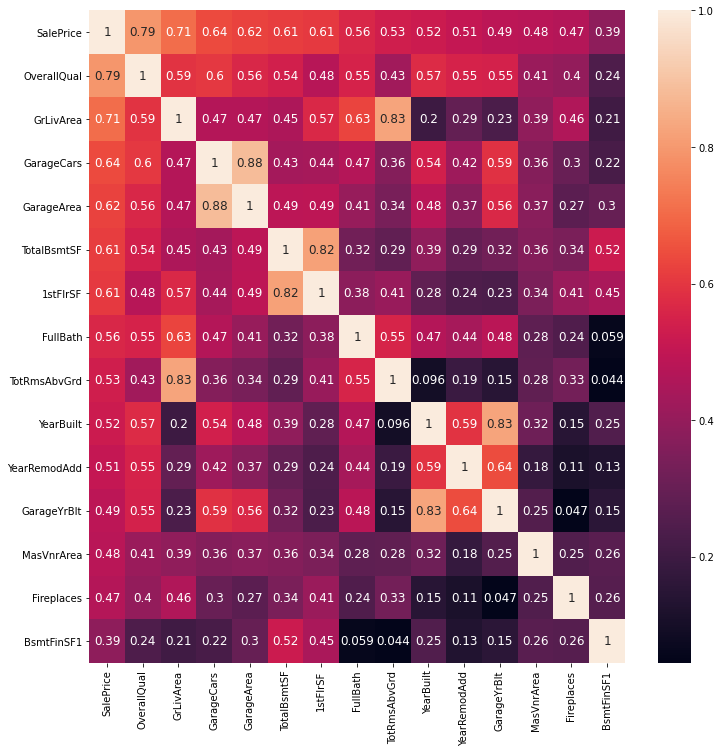

In [7]:
corrmat=train_n.corr()
n=15
top15_cols=corrmat.nlargest(n,'SalePrice').index
corrmat_top15=train_n[top15_cols].corr()
fig1,ax1=plt.subplots(figsize=(12,12))
sns.heatmap(corrmat_top15,square=False,annot=True,annot_kws={'size': 12})

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

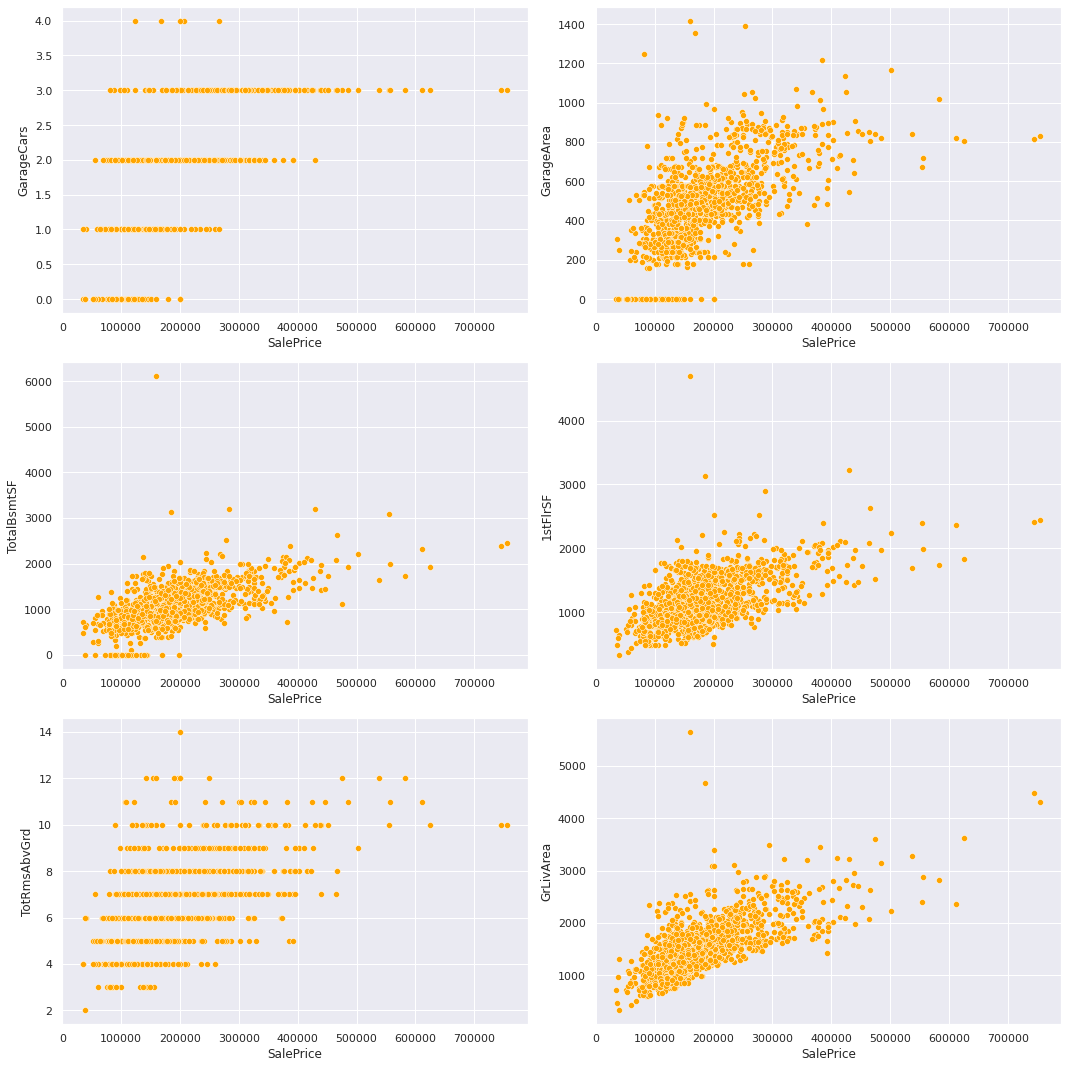

In [8]:
sns.set(style="darkgrid")
fig,ax=plt.subplots(3,2,figsize=(15,15))
sns.scatterplot(train_n['SalePrice'],train_n['GarageCars'],ax=ax[0][0],color='orange')
sns.scatterplot(train_n['SalePrice'],train_n['GarageArea'],ax=ax[0][1],color='orange')
sns.scatterplot(train_n['SalePrice'],train_n['TotalBsmtSF'],ax=ax[1][0],color='orange')
sns.scatterplot(train_n['SalePrice'],train_n['1stFlrSF'],ax=ax[1][1],color='orange')
sns.scatterplot(train_n['SalePrice'],train_n['TotRmsAbvGrd'],ax=ax[2][0],color='orange')
sns.scatterplot(train_n['SalePrice'],train_n['GrLivArea'],ax=ax[2][1],color='orange')
fig.tight_layout()

In [9]:
train_n1=train_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)
test_n1=test_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

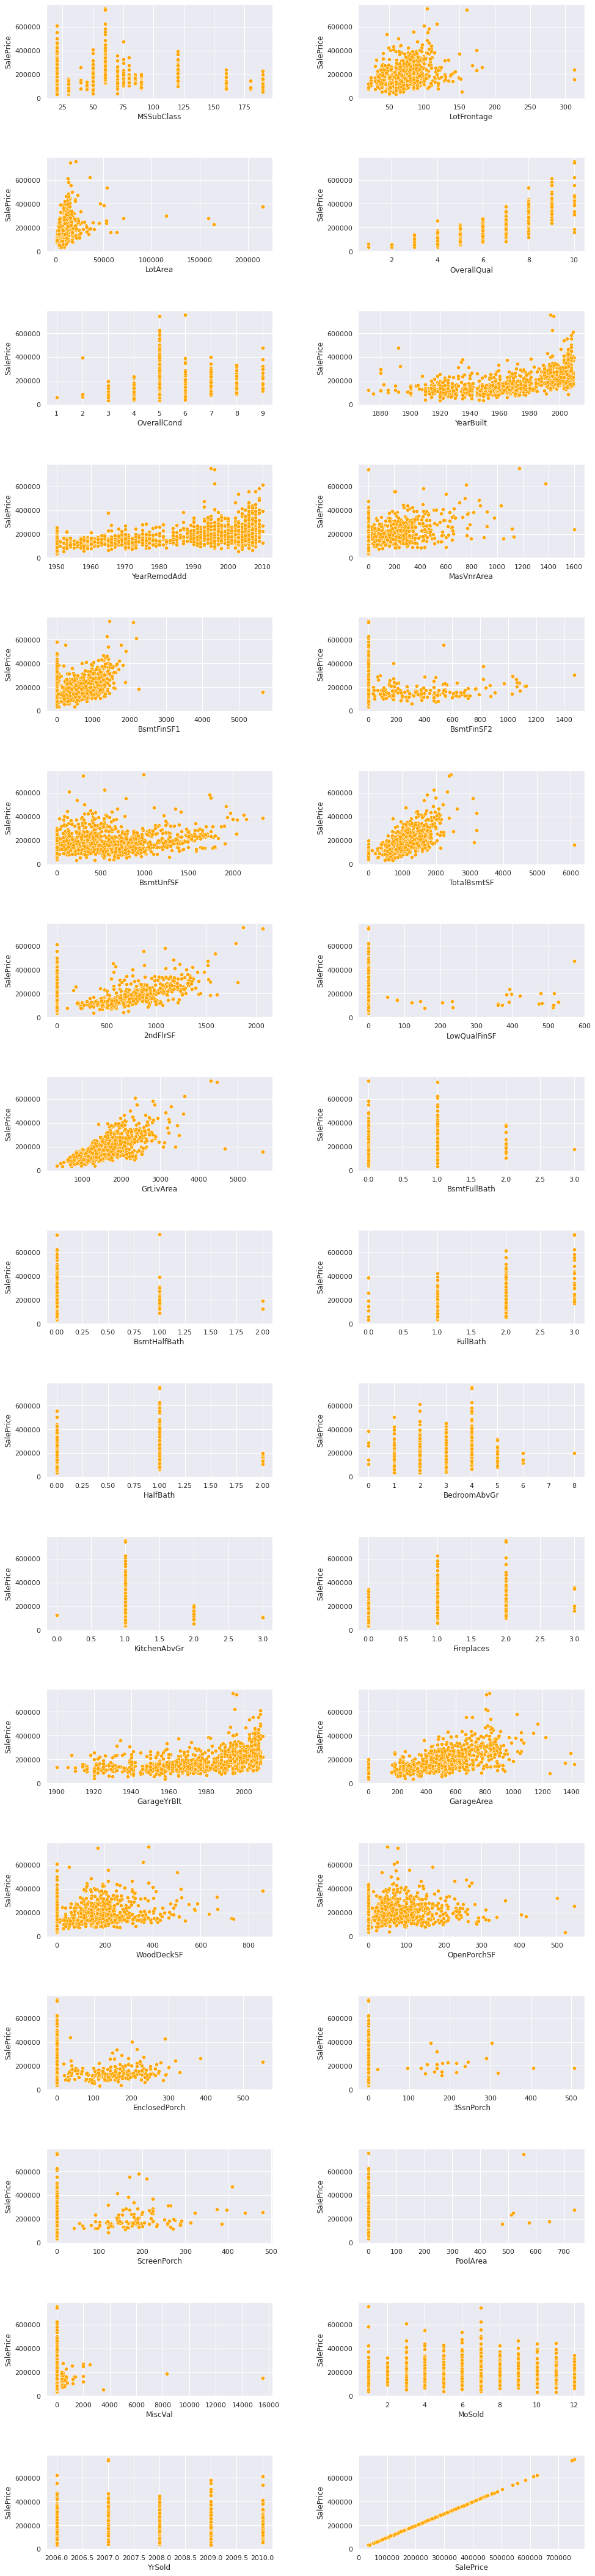

In [10]:
fig,ax=plt.subplots(17,2,figsize=(15,60))
def graph(x,y,r,c,title):
    sns.scatterplot(train_n1[x],y,color=('orange'),ax=ax[r][c])
    ax[r][c].set_xlabel(x)
    fig.tight_layout(pad=5.0)
for r,col in enumerate(train_n1.columns):
    c=r%2
    graph(col,train['SalePrice'],int(r/2),c,col)

In [11]:
non_linear=['MSSubClass','LotArea','OverallCond','LowQualFinSF','BsmtFullBath', 'BsmtHalfBath','FullBath', 'HalfBath','BedroomAbvGr',
            'KitchenAbvGr','Fireplaces','3SsnPorch','ScreenPorch' ,'PoolArea','MiscVal','MoSold', 'YrSold']
print("total non-linear",len(non_linear)," columns")

total non-linear 17  columns


In [12]:
linear_features=np.array([col for col in train_n1.columns if col not in non_linear])
linear_features

array(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'SalePrice'], dtype='<U13')

<AxesSubplot:>

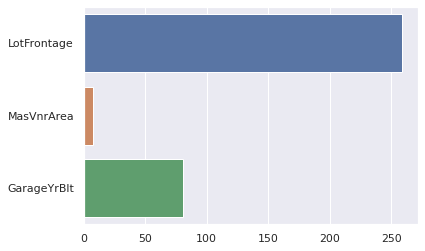

In [13]:
train_null=train_n1.isnull().sum()[train_n1.isnull().sum()!=0]
sns.barplot(y=train_null.index,x=train_null)

<AxesSubplot:>

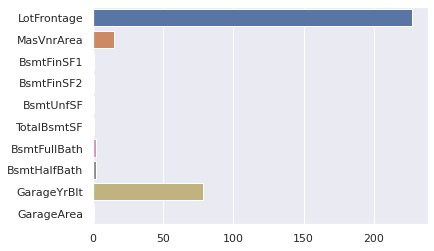

In [14]:
test_null=test_n1.isnull().sum()[test_n1.isnull().sum()!=0]
sns.barplot(y=test_null.index,x=test_null)

In [15]:
train_n1['GarageYrBlt']=train_n1['GarageYrBlt'].fillna(train_n1['GarageYrBlt'].median())
test_n1['GarageYrBlt']=test_n1['GarageYrBlt'].fillna(test_n1['GarageYrBlt'].median())

for col in train_n1.columns:
    train_n1[col]=train_n1[col].fillna(0)
for col in test_n1.columns:
    test_n1[col] = test_n1[col].fillna(0)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


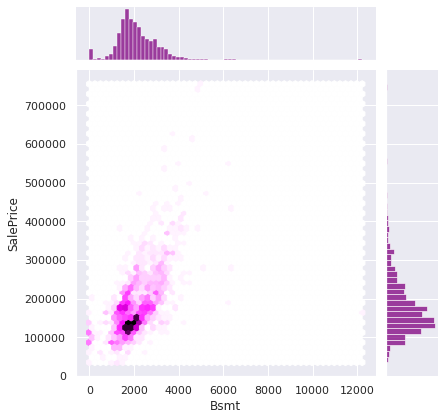

In [16]:
train_n1['Bsmt']=train_n1['BsmtFinSF1']+train_n1['BsmtFinSF2']+train_n1['BsmtUnfSF']+train_n1['TotalBsmtSF']
test_n1['Bsmt']=test_n1['BsmtFinSF1']+test_n1['BsmtFinSF2']+test_n1['BsmtUnfSF']+test_n1['TotalBsmtSF']
sns.jointplot(train_n1['Bsmt'],train_n1['SalePrice'],kind='hex',color='purple')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


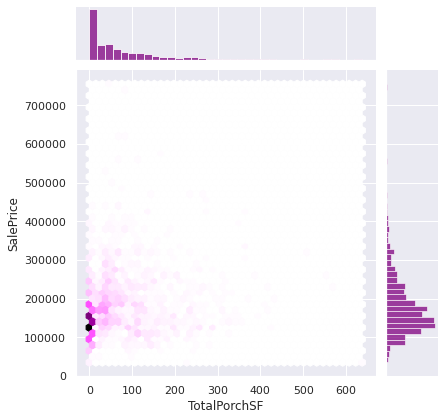

In [17]:
train_n1['TotalPorchSF']=train_n1['EnclosedPorch']+train_n1['OpenPorchSF']
test_n1['TotalPorchSF']=test_n1['EnclosedPorch']+test_n1['OpenPorchSF']

sns.jointplot(train_n1['TotalPorchSF'],train_n1['SalePrice'],kind='hex',color='purple')

In [18]:
linear_features=['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea','Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

In [19]:
train_n1[linear_features].columns

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'],
      dtype='object')

In [20]:
train_n1[linear_features].shape

(1460, 13)

In [21]:
test_n1[linear_features].shape

(1459, 13)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

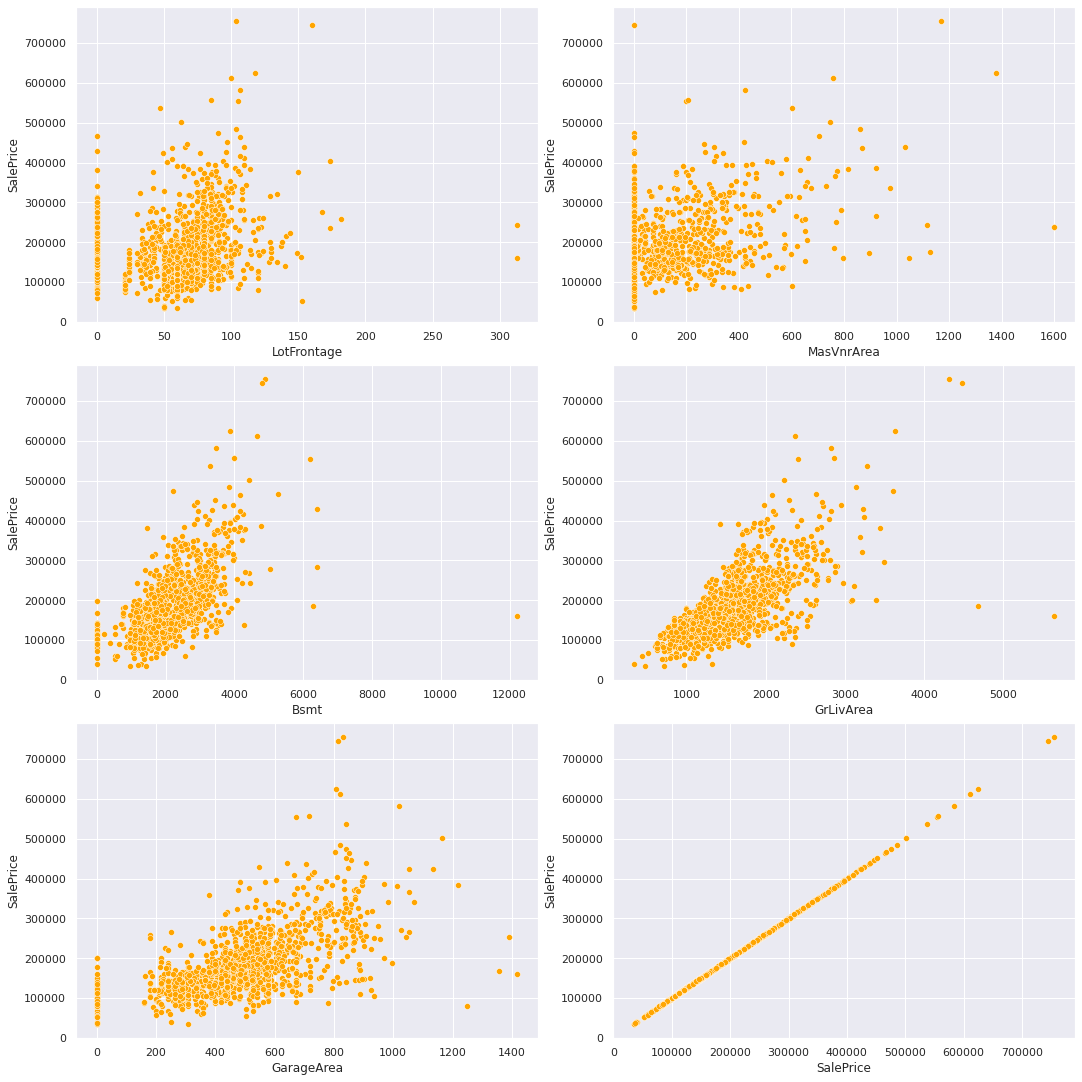

In [22]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
def graph(x,y,r,c,title):
    sns.scatterplot(train_n1[x],train_n1[y],color=('orange'),ax=ax[r][c])
    ax[r][c].set_ylabel(y)
    ax[r][c].set_xlabel(x)
    fig.tight_layout(pad=0.5)


for r,col in enumerate(np.array(['LotFrontage','MasVnrArea','Bsmt','GrLivArea','GarageArea','SalePrice'])):
    c=r%2
    graph(col,'SalePrice',int(r/2),c,col)

In [23]:
a=train_n1['LotFrontage'].sort_values(ascending=False).head(2)
b=train_n1['MasVnrArea'].sort_values(ascending=False).head(2)
c=train_n1['Bsmt'].sort_values(ascending=False).head(1)
d=train_n1['GrLivArea'].sort_values(ascending=False).head(2)
e=train_n1['GarageArea'].sort_values(ascending=False).head(3)
f=train_n1['SalePrice'].sort_values(ascending=False).head(2)

In [24]:
index=a.index
index=index.append(b.index)
index=index.append(c.index)
index=index.append(d.index)
index=index.append(e.index)
index=index.append(f.index)

In [25]:
train_n1=train_n1.drop(index).reset_index(drop=True)

In [26]:
Train_X_n=train_n1[linear_features]
Train_Y_n=train_n1['SalePrice']

In [27]:
Train_X_n.skew()

LotFrontage     -0.304896
OverallQual      0.178474
YearBuilt       -0.608484
YearRemodAdd    -0.496830
MasVnrArea       2.300035
Bsmt             0.483762
2ndFlrSF         0.766328
GrLivArea        0.811428
GarageYrBlt     -0.674187
GarageArea       0.047691
WoodDeckSF       1.555968
OpenPorchSF      2.339160
EnclosedPorch    3.077668
dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

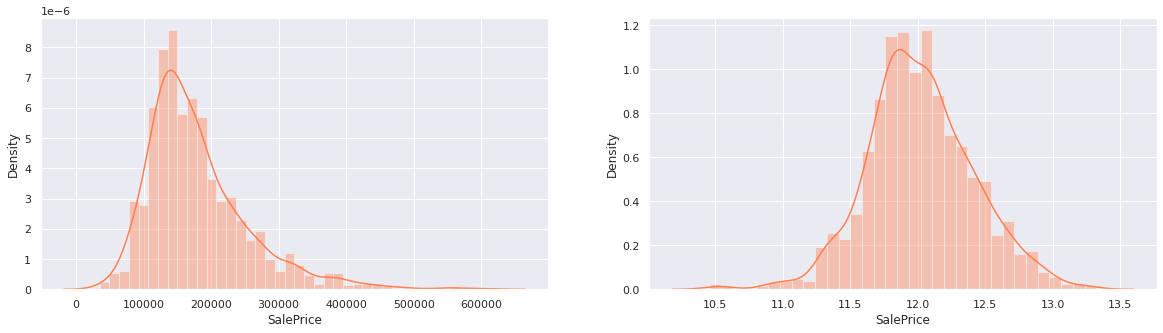

In [28]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.distplot(Train_Y_n,ax=ax[0],color='coral')
sns.distplot(np.log1p(Train_Y_n),ax=ax[1],color='coral')

In [29]:
y_train=np.log1p(Train_Y_n)

In [30]:
scaler=RobustScaler()
final_train_n=pd.DataFrame(scaler.fit_transform(Train_X_n),columns=Train_X_n.columns)
final_test_n=pd.DataFrame(scaler.fit_transform(test_n1[linear_features]),columns=Train_X_n.columns)

In [31]:
final_train_n.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Bsmt,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,0.054795,0.5,0.673913,0.263158,1.209877,-0.269618,1.173077,0.394104,0.589744,0.281690,0.000000,0.544118,0.0
1,0.465753,0.0,0.086957,-0.447368,0.000000,0.547284,0.000000,-0.301009,-0.102564,-0.072435,1.773810,-0.352941,0.0
2,0.136986,0.5,0.630435,0.236842,1.000000,-0.140845,1.189560,0.512025,0.538462,0.523139,0.000000,0.264706,0.0
3,-0.082192,0.5,-1.239130,-0.605263,0.000000,-0.470825,1.038462,0.404965,0.461538,0.659960,0.000000,0.161765,272.0
4,0.575342,1.0,0.608696,0.184211,2.160494,0.311871,1.446429,1.151280,0.512821,1.440644,1.142857,0.882353,0.0


In [32]:
final_test_n.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Bsmt,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,0.500000,-0.5,-0.250000,-0.756098,0.000000,-0.203846,0.000000,-0.888152,-0.444444,0.967118,0.833333,-0.388889,0.0
1,0.529412,0.0,-0.312500,-0.829268,0.666667,0.655769,0.000000,-0.170671,-0.518519,-0.649903,2.339286,0.111111,0.0
2,0.323529,-0.5,0.500000,0.146341,0.000000,-0.115385,1.036982,0.326429,0.444444,0.007737,1.261905,0.083333,0.0
3,0.441176,0.0,0.520833,0.146341,0.123457,-0.119231,1.002959,0.285004,0.469136,-0.038685,2.142857,0.111111,0.0
4,-0.588235,1.0,0.395833,0.000000,0.000000,0.561538,0.000000,-0.251864,0.320988,0.100580,0.000000,0.750000,0.0


**EDA on Categorical Features**

<AxesSubplot:>

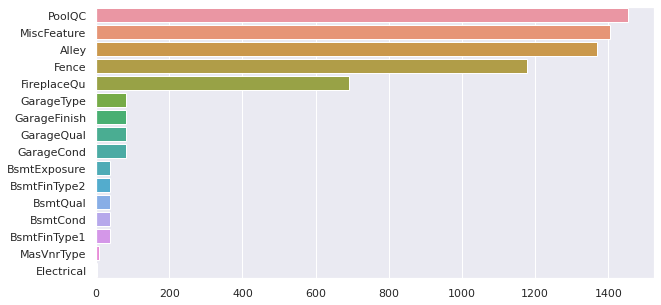

In [33]:
fig=plt.figure(figsize=(10,5))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

<AxesSubplot:>

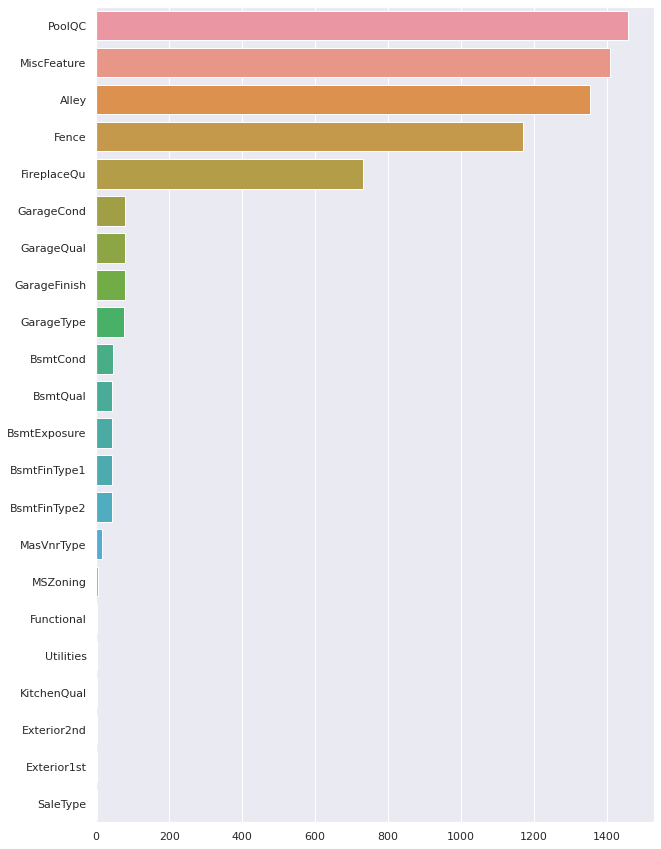

In [34]:
fig=plt.figure(figsize=(10,15))
test_null=test_c.isnull().sum()[test_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=test_null.index,x=test_null)

In [35]:
train_c.dropna(thresh=len(train_c)*0.9,axis=1,inplace=True)

In [36]:
test_c.dropna(thresh=len(test_c)*0.9,axis=1,inplace=True)

In [37]:
train_c['Electrical']=train_c["Electrical"].fillna(method='ffill')
test_c['SaleType']=test_c['SaleType'].fillna(method='ffill')
test_c['KitchenQual']=test_c['KitchenQual'].fillna(method='ffill')
test_c['Exterior1st']=test_c['Exterior1st'].fillna(method='ffill')
test_c['Exterior2nd']=test_c['Exterior2nd'].fillna(method='ffill')
test_c['Functional']=test_c['Functional'].fillna(method='ffill')
test_c['Utilities']=test_c['Utilities'].fillna(method='ffill')
test_c['MSZoning']=test_c['MSZoning'].fillna(method='ffill')

In [38]:
for col in train_c.columns:
    train_c[col]=train_c[col].fillna("None")
for col in test_c.columns:
    test_c[col] = test_c[col].fillna("None")

In [39]:
print("Train null values : ",len(train_c.isnull().sum()[train_c.isnull().sum()!=0]))
print("Test null values : ",len(test_c.isnull().sum()[test_c.isnull().sum()!=0]))

Train null values :  0
Test null values :  0


In [40]:
train_c=train_c.drop(index).reset_index(drop=True)
train_c.shape

(1451, 38)

In [41]:
test_c.shape

(1459, 38)

In [42]:
num_train=train_n1[['OverallCond','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenAbvGr',
'BedroomAbvGr','Fireplaces','MoSold','YrSold']]
num_test=test_n1[['OverallCond','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenAbvGr',
'BedroomAbvGr','Fireplaces','MoSold','YrSold']]
print(num_train.shape)
print(num_test.shape)
numerical_categorical_feature=c = pd.concat((num_train,num_test),sort=False)
print(numerical_categorical_feature.shape)
numerical_categorical_feature=numerical_categorical_feature.astype('O')

(1451, 10)
(1459, 10)
(2910, 10)


<AxesSubplot:xlabel='OverallCond'>

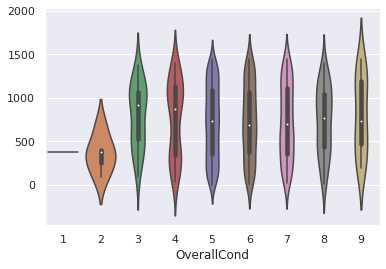

In [43]:
sns.violinplot(x=num_train['OverallCond'],y=num_train['OverallCond'].index)

In [44]:
numerical_categorical_feature

,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,BedroomAbvGr,Fireplaces,MoSold,YrSold
0,5,1.0,0.0,2,1,1,3,0,2,2008
1,8,0.0,1.0,2,0,1,3,1,5,2007
2,5,1.0,0.0,2,1,1,3,1,9,2008
3,5,1.0,0.0,1,0,1,3,1,2,2006
4,5,1.0,0.0,2,1,1,4,1,12,2008
...,...,...,...,...,...,...,...,...,...,...
1454,7,0.0,0.0,1,1,1,3,0,6,2006
1455,5,0.0,0.0,1,1,1,3,0,4,2006
1456,7,1.0,0.0,1,0,1,4,1,9,2006
1457,5,0.0,1.0,1,0,1,3,0,7,2006


In [45]:
numerical_categorical_feature=pd.get_dummies(numerical_categorical_feature)
num_train_dummy=numerical_categorical_feature[:1451]
num_test_dummy=numerical_categorical_feature[1451:].reset_index(drop=True)
print(num_train_dummy.shape)
print(num_test_dummy.shape)

(1451, 58)
(1459, 58)


In [46]:
c = pd.concat((train_c, test_c), sort=False).reset_index(drop=True)

In [47]:
c1=pd.get_dummies(c)

In [48]:
final_train_c=c1.iloc[:train_c.shape[0]]
final_train_c.shape

(1451, 242)

In [49]:
final_test_c=c1.iloc[train_c.shape[0]:]
final_test_c=final_test_c.reset_index(drop=True)
final_test_c.shape

(1459, 242)

In [50]:
final_train_c=final_train_c.merge(num_train_dummy,left_index=True,right_index=True)
final_test_c=final_test_c.merge(num_test_dummy,left_index=True,right_index=True)

In [51]:
x_train=final_train_n.merge(final_train_c,left_index=True,right_index=True).reset_index(drop=True)
x_test=final_test_n.merge(final_test_c,left_index=True,right_index=True).reset_index(drop=True)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train,test_size = .3, random_state=42)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge=Ridge()
parameters={'alpha':[x for x in [0.1,0.2,0.5,0.8,1,1.5,2,2.5,3]]}
ridge_reg=GridSearchCV(ridge,param_grid=parameters)
ridge_reg.fit(X_train,Y_train)
print("The best Value of Alpha is:",ridge_reg.best_params_)

The best Value of Alpha is: {'alpha': 3}


In [54]:
ridge_mod=Ridge(alpha=3)
ridge_mod.fit(x_train,y_train)
y_pred_train=ridge_mod.predict(X_train)
y_pred_test=ridge_mod.predict(X_test)

print('Root Mean Square Error train= '+str(np.sqrt(mean_squared_error(Y_train,y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

Root Mean Square Error train= 0.09313009628770597
Root Mean Square Error test = 0.09881992947702885


In [55]:
from sklearn.linear_model import Lasso

Lasso_reg =Lasso()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,1]]}

Lasso_reg=GridSearchCV(Lasso_reg, param_grid=parameters)
Lasso_reg.fit(X_train,Y_train)
print("The best value of Alpha is: ",Lasso_reg.best_params_,Lasso_reg.best_score_)

The best value of Alpha is:  {'alpha': 0.0005} 0.9160648439615302


In [56]:
Lasso_reg =Lasso(alpha=0.0005)
Lasso_reg.fit(x_train,y_train)
y_pred_test=Lasso_reg.predict(X_test)
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

Root Mean Square Error test = 0.10498544801585664


In [57]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
params={"max_depth":[15,20,25,30],"n_estimators":[25,35,45,55]}
rf_reg = GridSearchCV(rf, params, cv = 10, n_jobs =10)
rf_reg.fit(X_train, Y_train)
print(rf_reg.best_estimator_)

RandomForestRegressor(max_depth=25, n_estimators=25)


In [58]:
best_estimator=rf_reg.best_estimator_
y_pred_test = best_estimator.predict(X_test)
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

Root Mean Square Error test = 0.16124125308584672


In [59]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()
params = {'learning_rate': [0.10,0.14,0.15,0.16, 0.2], 'max_depth': [1,2,3,5] }

xgbr_reg = GridSearchCV(xgbr, params, cv = 10, n_jobs =1)
xgbr_reg.fit(X_train,Y_train)

print("Best params:{}".format(xgbr_reg.best_params_))

best_x = xgbr_reg.best_estimator_
y_train_pred_x = best_x.predict(X_train)
y_val_pred_x = best_x.predict(X_test)

Best params:{'learning_rate': 0.2, 'max_depth': 3}


In [60]:
print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(Y_train, y_train_pred_x))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_val_pred_x)))) 

Root Mean Square Error train = 0.06498210593881741
Root Mean Square Error test = 0.13503308264183353


In [61]:
y_test=ridge_mod.predict(x_test)

In [62]:
final_y_test=np.expm1(y_test)

In [63]:
final_y_test

array([119692.72151776, 158867.16199491, 179545.1414591 , ...,
       160034.64154829, 118430.33191131, 217345.85496036])

In [64]:
sample=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission=pd.DataFrame({"Id":sample["Id"],
                          "SalePrice":final_y_test})
submission.to_csv('submission.csv',index=False)


In [65]:
submission.head(20)

,Id,SalePrice
0,1461,119692.721518
1,1462,158867.161995
2,1463,179545.141459
3,1464,199058.683347
4,1465,189714.378205
5,1466,174615.065152
6,1467,176756.827113
7,1468,166581.554468
8,1469,195106.629450
9,1470,119239.877125
